In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from nsepy import get_history
from datetime import date
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [32]:
sbi = get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
hdfc = get_history(symbol= 'HDFCBANK', start=date(2015,1,1), end=date(2022,3,1))
icici = get_history(symbol= 'ICICIBANK', start=date(2015,1,1), end=date(2022,3,1))
kotak = get_history(symbol= 'KOTAKBANK', start=date(2015,1,1), end=date(2022,3,1))

In [33]:
stocks = [sbi, hdfc, icici, kotak]
for i in stocks:
    i.drop(['Turnover', 'Trades', 'Deliverable Volume', '%Deliverble', 'Symbol', 'Series'], axis=1, inplace=True)

In [34]:
sbi.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume
Date,,,,,,,,
2015-01-01,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488
2015-01-02,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094
2015-01-05,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716
2015-01-06,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257
2015-01-07,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745


In [35]:
hdfc.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume
Date,,,,,,,,
2015-01-01,951.60,951.0,954.40,945.05,952.30,952.05,949.13,886235
2015-01-02,952.05,950.4,969.30,950.40,968.00,965.30,965.25,1475096
2015-01-05,965.30,970.0,970.55,955.10,958.50,957.15,959.15,1199000
2015-01-06,957.15,954.0,956.55,937.55,941.45,942.25,948.51,2054920
2015-01-07,942.25,939.7,951.35,936.25,944.80,945.00,946.73,1436528


In [36]:
icici.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume
Date,,,,,,,,
2015-01-01,353.10,352.7,353.45,350.20,353.0,352.30,351.84,2348437
2015-01-02,352.30,352.0,363.50,352.00,363.0,362.30,360.06,7520900
2015-01-05,362.30,365.3,367.40,361.50,363.5,363.05,364.41,9378264
2015-01-06,363.05,359.4,359.90,346.20,346.4,347.65,351.80,12074934
2015-01-07,347.65,345.6,346.25,335.45,340.5,338.25,339.25,19322120


In [37]:
kotak.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume
Date,,,,,,,,
2015-01-01,1263.90,1263.8,1265.00,1251.10,1261.75,1258.60,1259.52,250998
2015-01-02,1258.60,1261.0,1279.00,1258.30,1278.00,1271.55,1271.97,631815
2015-01-05,1271.55,1272.1,1278.85,1262.00,1267.60,1266.45,1266.77,305115
2015-01-06,1266.45,1255.0,1262.25,1233.55,1253.00,1251.35,1251.25,1134543
2015-01-07,1251.35,1247.5,1303.95,1247.50,1272.90,1271.50,1280.55,1785887


<AxesSubplot:xlabel='Date', ylabel='Close'>

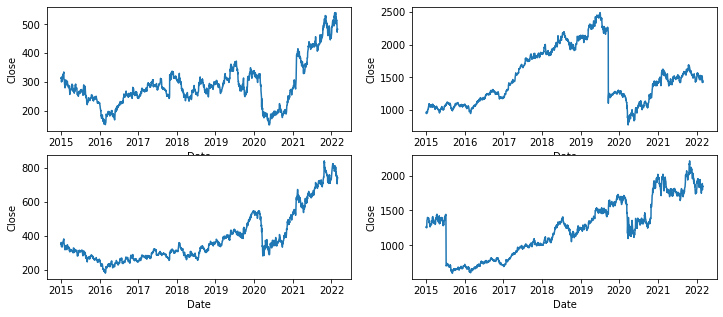

In [38]:
fig, ax = plt.subplots(2,2,figsize=(12,5))
sns.lineplot(x='Date', y='Close', data=sbi, ax=ax[0][0])
sns.lineplot(x='Date', y='Close', data=hdfc, ax=ax[0][1])
sns.lineplot(x='Date', y='Close', data=icici, ax=ax[1][0])
sns.lineplot(x='Date', y='Close', data=kotak, ax=ax[1][1])
